In [2]:
import spacy
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from stop_words_pl import get_stop_words_pl

c:\Users\wilko\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Czyszczenie danych

In [3]:
df_raw = pd.read_csv(r'C:\Users\wilko\Desktop\Studia\Projekty swoje\Python\Machine learning\NLP-text-classification\data\descriptions\training_data.csv', header=0)
df = df_raw.copy()
df.head()

,Label,Opis
0,2,Do wynajęcia mieszkanie dwupokojowe z ogródkie...
1,2,"Wygodne, rozkładowe, częściowo umeblowane mies..."
2,2,Do wynajęcia mieszkanie 70m z tarasem o powier...
3,2,Na wynajem - jasne i przytulne mieszkanie dwup...
4,2,"[PL/EN] Piękne, stylowe i wysmakowan..."


In [4]:
df['Label'].value_counts()

0    268
1    250
2    249
Name: Label, dtype: int64

### Zapisanie opisów małymi literami

In [5]:
df['Opis'] = df['Opis'].str.lower()
df['Opis'][0]

'do wynajęcia mieszkanie dwupokojowe z ogródkiem i garażem w wilanowie zawadach przy ul. bruzdowej 100d. mieszkanie gotowe do wynajęcia, dostępne od zaraz, częściowo umeblowane (kuchnia, łazienka i przedpokój). wygodne, przestronne, w sypialni duża szafa, ogródek około 40 m2. sypialnia o powierzchni 15 m2 z dużymi oknami i roletami. do mieszkania przynależy miejsce parkingowe oraz duża komórka lokatorska na poziomie -1 w cenie 350 zł. komunikacja autobusowa przy placu vogla i ulicy sytej, tam też znajduje się mini galeria, lidl, biedronka, restauracje, punkty usługowe, miejsca spotkań. osiedle zamknięte z wyjściem i wyjazdem do wału zawadowskiego, tuż za wałem jest wisła, dużo zieleni, miejsc do spacerów, trasa rowerowa, wiślańskie plaże. podana cena jest bez czynszu administracyjnego, który wynosi 950 zł. wymagany najem okazjonalny. zapraszam zobacz wirtualny spacer: https://panoramy.galactica.pl/virgo/423768pośrednik odpowiedzialny zawodowo za wykonanie umowy pośrednictwa:  (licencja

### Usunięcie linków, znaków specjalnych, interpunkcji oraz liczb

In [6]:
def remove_special_chars(text):
    if text is not None:
        text = re.sub(r'http\S+', '', text)
        cleaned_text = re.sub(r'[^\w\s]', '', text) 
        return cleaned_text
    else:
        return None

df['Opis'] = df['Opis'].str. replace('\d+', '')
df['Opis'] = df['Opis'].apply(remove_special_chars)

df['Opis'][0]

C:\Users\wilko\AppData\Local\Temp\ipykernel_12916\3048161841.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Opis'] = df['Opis'].str. replace('\d+', '')


'do wynajęcia mieszkanie dwupokojowe z ogródkiem i garażem w wilanowie zawadach przy ul bruzdowej d mieszkanie gotowe do wynajęcia dostępne od zaraz częściowo umeblowane kuchnia łazienka i przedpokój wygodne przestronne w sypialni duża szafa ogródek około  m sypialnia o powierzchni  m z dużymi oknami i roletami do mieszkania przynależy miejsce parkingowe oraz duża komórka lokatorska na poziomie  w cenie  zł komunikacja autobusowa przy placu vogla i ulicy sytej tam też znajduje się mini galeria lidl biedronka restauracje punkty usługowe miejsca spotkań osiedle zamknięte z wyjściem i wyjazdem do wału zawadowskiego tuż za wałem jest wisła dużo zieleni miejsc do spacerów trasa rowerowa wiślańskie plaże podana cena jest bez czynszu administracyjnego który wynosi  zł wymagany najem okazjonalny zapraszam zobacz wirtualny spacer  odpowiedzialny zawodowo za wykonanie umowy pośrednictwa  licencja nr '

### Stemming i lemantyzacja

In [7]:
nlp = spacy.load('pl_core_news_md')

opisy_mieszkan = df['Opis']

przetworzone_opisy = []
for opis in df['Opis']:
    doc = nlp(opis)
    przetworzony_opis = ' '.join([token.lemma_ for token in doc if not token.is_stop])
    przetworzone_opisy.append(przetworzony_opis)

df['Opis'] = przetworzone_opisy
df['Opis'][0]

'wynająć mieszkanie dwupokojowy ogródek garaż wilanowa zawada ulica bruzdowy d mieszkanie gotowy wynająć dostępny zaraz częściowo umeblować kuchnia łazienka przedpokój wygodny przestronny sypialnia duży szafa ogródek   metr sypialnia powierzchnia   metr duży okno rolet mieszkanie przynależeć miejsce parkingowy duży komórka lokatorsky poziom   cena   złoty komunikacja autobusowy plac vogla ulica syty znajdować mini galeria lidl biedronka restauracja punkt usługowy miejsce spotkanie osiedle zamknięty wyjście wyjazd wał zawadowskiy tuż wał wisły zieleń miejsce spacer trasa rowerowy wiślański plaża podać cena czynsz administracyjny wynosić   złoty wymagać najem okazjonalny zapraszać zobaczyć wirtualny spacer   odpowiedzialny zawodowo wykonać umowa pośrednictwo   licencja numer'

### Usunięcie pojedyńczych znaków pozwstałych w trakcie czysczenia tekstu

In [8]:
def remove_single_letters(text):
    return re.sub(r'\b\w\b\s*', '', text)

# Zastosowanie funkcji do kolumny 'opis_mieszkania'
df['Opis'] = df['Opis'].apply(remove_single_letters)
df['Opis'][0]

'wynająć mieszkanie dwupokojowy ogródek garaż wilanowa zawada ulica bruzdowy mieszkanie gotowy wynająć dostępny zaraz częściowo umeblować kuchnia łazienka przedpokój wygodny przestronny sypialnia duży szafa ogródek   metr sypialnia powierzchnia   metr duży okno rolet mieszkanie przynależeć miejsce parkingowy duży komórka lokatorsky poziom   cena   złoty komunikacja autobusowy plac vogla ulica syty znajdować mini galeria lidl biedronka restauracja punkt usługowy miejsce spotkanie osiedle zamknięty wyjście wyjazd wał zawadowskiy tuż wał wisły zieleń miejsce spacer trasa rowerowy wiślański plaża podać cena czynsz administracyjny wynosić   złoty wymagać najem okazjonalny zapraszać zobaczyć wirtualny spacer   odpowiedzialny zawodowo wykonać umowa pośrednictwo   licencja numer'

### Podział na dane treningowe i testowe

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['Opis'], df['Label'], random_state=42, test_size=0.2, shuffle=True)


## Wektoryzacja danych tekstowych z wykorzystaniem macierzy TF-IDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=80)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

### Model maszyny wektorów nośnych

In [11]:
from sklearn.svm import SVC

svm_clf = SVC(C=2, kernel='linear', gamma='auto')
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)
print(svm_clf.score(X_test, y_test))

0.8311688311688312


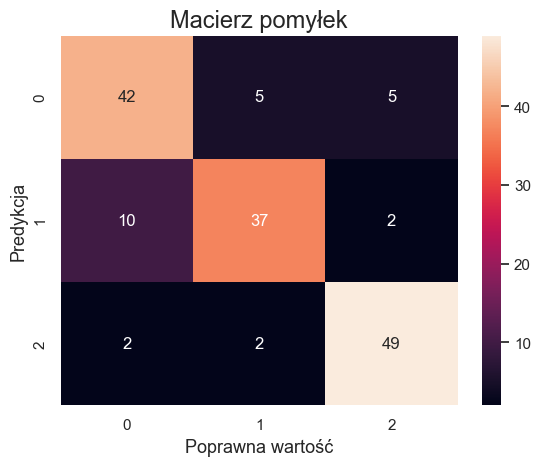

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=[0, 1, 2],
            yticklabels=[0, 1, 2]
    )
plt.ylabel('Predykcja', fontsize=13)
plt.xlabel('Poprawna wartość', fontsize=13)
plt.title('Macierz pomyłek', fontsize=17)
plt.show()

### Model drzewa decyzyjnego

In [13]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(criterion="gini", max_depth=3)

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)
print(dt_clf.score(X_test, y_test))

0.8766233766233766


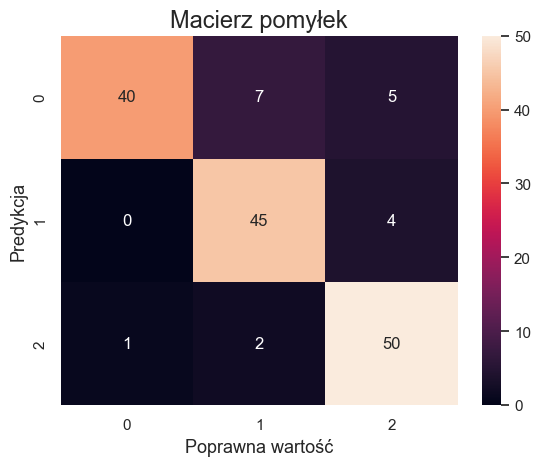

In [14]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=[0, 1, 2],
            yticklabels=[0, 1, 2]
    )
plt.ylabel('Predykcja', fontsize=13)
plt.xlabel('Poprawna wartość', fontsize=13)
plt.title('Macierz pomyłek', fontsize=17)
plt.show()

### Model regresji logistycznej

In [15]:
from sklearn.linear_model import LogisticRegression

logreg_clf = LogisticRegression()
logreg_clf.fit(X_train, y_train)

y_pred = logreg_clf.predict(X_test)
print(logreg_clf.score(X_test, y_test))

0.7792207792207793


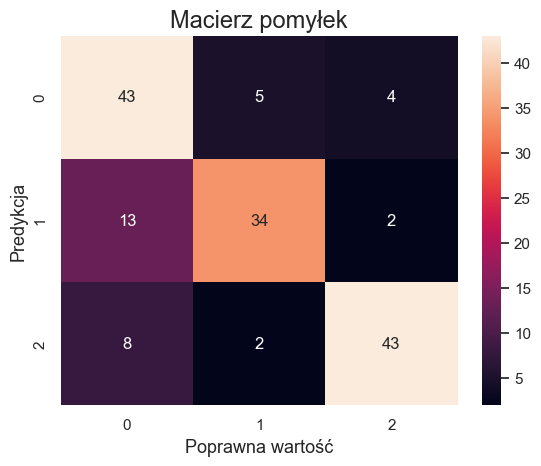

In [16]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=[0, 1, 2],
            yticklabels=[0, 1, 2]
    )
plt.ylabel('Predykcja', fontsize=13)
plt.xlabel('Poprawna wartość', fontsize=13)
plt.title('Macierz pomyłek', fontsize=17)
plt.show()

### Model lasów losowych

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(100, max_depth=3, criterion='entropy')
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)
print(rf_clf.score(X_test, y_test))

0.8246753246753247


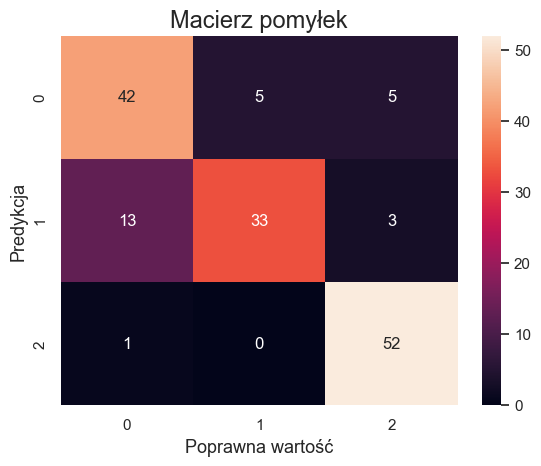

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=[0, 1, 2],
            yticklabels=[0, 1, 2]
    )
plt.ylabel('Predykcja', fontsize=13)
plt.xlabel('Poprawna wartość', fontsize=13)
plt.title('Macierz pomyłek', fontsize=17)
plt.show()

## Wektoryzacja danych tekstowych z wykorzystaniem funkcji CountVectorizer

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df['Opis'], df['Label'], random_state=42, test_size=0.2, shuffle=True)

count_vec = CountVectorizer()
X_train = count_vec.fit_transform(X_train)
X_test = count_vec.transform(X_test)

### Model drzewa decyzyjnego

In [27]:
dt_clf = DecisionTreeClassifier(criterion="gini", max_depth=3)

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)
print(dt_clf.score(X_test, y_test))

0.8636363636363636


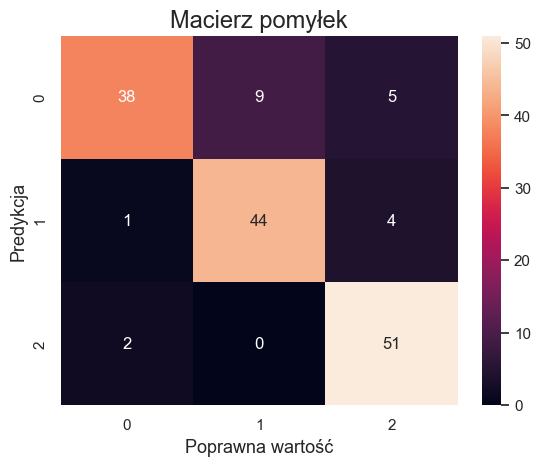

In [25]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=[0, 1, 2],
            yticklabels=[0, 1, 2]
    )
plt.ylabel('Predykcja', fontsize=13)
plt.xlabel('Poprawna wartość', fontsize=13)
plt.title('Macierz pomyłek', fontsize=17)
plt.show()

### Model maszyny wektorów nośnych

In [34]:
svm_clf = SVC(C=3, kernel='linear', gamma='auto')
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)
print(svm_clf.score(X_test, y_test))

0.7532467532467533


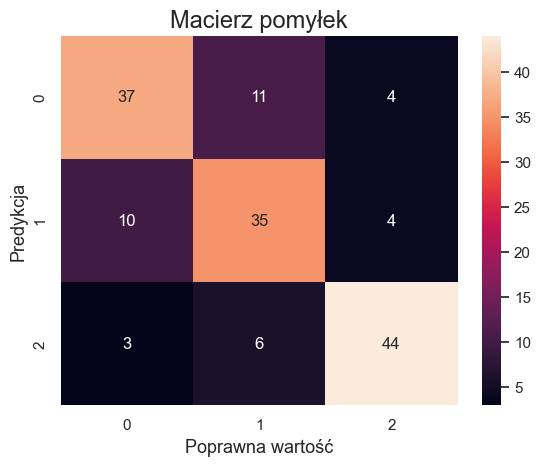

In [36]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=[0, 1, 2],
            yticklabels=[0, 1, 2]
    )
plt.ylabel('Predykcja', fontsize=13)
plt.xlabel('Poprawna wartość', fontsize=13)
plt.title('Macierz pomyłek', fontsize=17)
plt.show()

## Wektoryzacja danych tekstowych z wykorzystaniem bigramów

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df['Opis'], df['Label'], random_state=42, test_size=0.2, shuffle=True)

bigram = CountVectorizer(ngram_range=(1, 2), min_df=1)
X_train = bigram.fit_transform(X_train)
X_test = bigram.transform(X_test)

### Model drzewa decyzyjnego

In [42]:
dt_clf = DecisionTreeClassifier(criterion="gini", max_depth=3)

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)
print(dt_clf.score(X_test, y_test))

0.8766233766233766


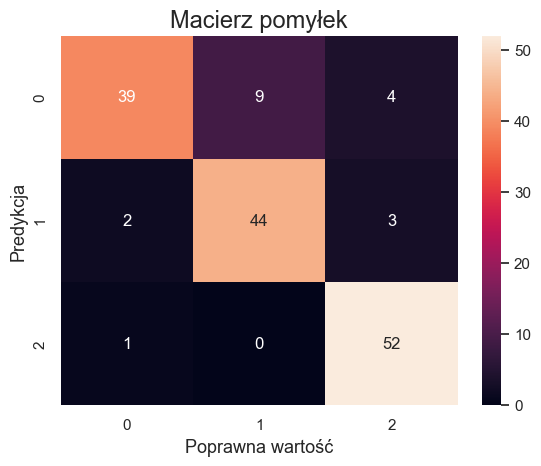

In [43]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=[0, 1, 2],
            yticklabels=[0, 1, 2]
    )
plt.ylabel('Predykcja', fontsize=13)
plt.xlabel('Poprawna wartość', fontsize=13)
plt.title('Macierz pomyłek', fontsize=17)
plt.show()

### Model maszyny wektorów nośnych

In [54]:
svm_clf = SVC(C=3, kernel='linear', gamma='auto')
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)
print(svm_clf.score(X_test, y_test))

0.7597402597402597


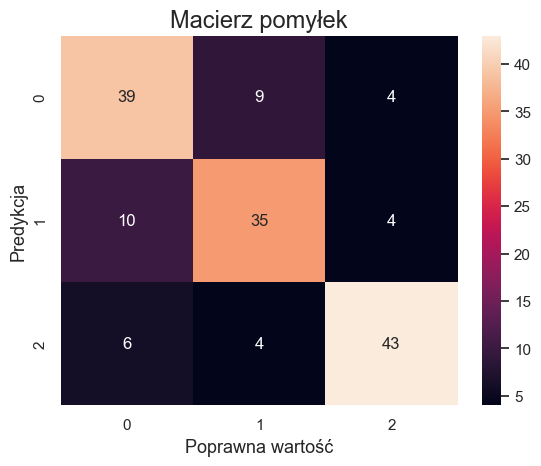

In [55]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=[0, 1, 2],
            yticklabels=[0, 1, 2]
    )
plt.ylabel('Predykcja', fontsize=13)
plt.xlabel('Poprawna wartość', fontsize=13)
plt.title('Macierz pomyłek', fontsize=17)
plt.show()